In [1]:
import pandas as pd
import numpy as np

In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

In [3]:
from fuzzywuzzy import process, fuzz

In [4]:
import pgeocode

In [5]:
def normalize_name(name):
    if ',' in name:
        last_name, first_name = name.split(', ')
        return f"{first_name} {last_name}"
    else:
        return name

In [6]:
def fuzzy_merge(df1, df2, key1, key2, threshold=90):
    matched_names = []

    for name in df1[key1]:
        match, score, _ = process.extractOne(name, df2[key2], scorer=fuzz.token_sort_ratio)
        if score >= threshold:
            matched_names.append((name, match, score))

    return pd.DataFrame(matched_names, columns=[key1, key2, 'score'])

In [7]:
org_key = ['1199 SEIU','32 BJ SEIU', '536 Laguadia Place','57th Ave Liquor and Wine', 'A Print Solution LLC', 'Abdoulaye Barry', 'ACEC New York City',
       'ActBlue', 'AFSCME-Local 1407', 'AIA New York Chapter','Alan Maisel for Council', 'Alessandra Biaggi, Committee t',
       'Allied Printing Trades Counci', 'Allied Printing Trades Council',
       'Alphajor Barrie', 'Althea & Friends TIE', 'Amalgamated Transit Union',
       'American Council of Engineerin', 'Assistant Deputy Wardens/Deput',
       'BRAB PAC','Bricklayers & Allied Craftwork', 'Building &  Construction Trade',
       'Carlina 2021', "Carolyn's PAC", 'Central Labor Council, AFL-CIO',
       'Civil Service Employee Politic', 'Committee on Political Educati',
       'Communications Workers of Amer', 'Correction Officers Benevolent', 'Council of School Supervisors', 'COurage to Change NY',
       'Courage to Change NYC', "Cozen O'Connor PAC", 'CWA District One', 'D&M PAC', 'Dianne Morales for NYC',
       'District Council 37', 'Doctors Council SEIU' ,'Downtown Women for Change',
       "Edgewater Park Owners' Coopera", "Emily's List-NF Fund", 'Empire Dental Political Action',
       'Friends of Ralph Perfetto', 'Greenberg Taurig',
       'IBT Joint Council No 16 PAC', 'Keith For NYC',
       'Local 813 IBT Political Action', 'Local 983',
       'Madison Square Garden NY PAC', 'Mason Tenders District Council',
       'Metavante Corp', 'Neighborhood Preservation PAC',
       'New York City Central Labor Co', 'New York State Laborers', 'New York State Nurses Associat',
       'New Yorkers for Savino', 'New Yorkers Putting Students F',
       'NYC District Council Of Carpen',
       'NYC DSA', 
       'Police Benevolent Association', 'PSC PAC', 'Riley for the Bronx',
       'RPAC of New York State', 'Stonewall Democratic Club of N',
       'StreetsPac', 'Teamsters Local Union No 202',
       'Tile, Marble, & Terrazo Local', 'Transport Workers Union Local',
       'U.A. Steamfitters L.U. 638', 'United Federation of Teachers','ACEC New York City']

In [8]:
all_cc = pd.read_csv('../data/candidates/all_cc.csv')
all_cc_df = all_cc[['REFNO', 'DATE','NAME','RECIPNAME', 'AMNT','SCHEDULE','C_CODE','PURPOSECD','OCCUPATION','EMPNAME','ZIP']]

C:\Users\samtg\AppData\Local\Temp\ipykernel_26904\676309483.py:1: DtypeWarning: Columns (46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  all_cc = pd.read_csv('../data/candidates/all_cc.csv')


In [9]:
faction_compare = pd.read_csv('../data/faction_compare.csv') 

In [10]:
all_cc_df['C_CODE'].value_counts()

C_CODE
IND      161629
PCOMP      1136
CAN         840
FAM         542
OTHR        114
SPO          93
EMPO         91
CORP         84
PCOMC        82
PCOMZ        54
LLC          26
PART          3
Name: count, dtype: int64

In [11]:
all_cc_df['normalized_mem'] = all_cc_df['RECIPNAME'].apply(lambda x: normalize_name(x))

C:\Users\samtg\AppData\Local\Temp\ipykernel_26904\2387651597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_cc_df['normalized_mem'] = all_cc_df['RECIPNAME'].apply(lambda x: normalize_name(x))


In [12]:
all_cc_df['normalized_mem'].unique()

array(['Rodrigo Camarena', 'Jenny L Low', 'James F Gennaro',
       'Leslie Boghosian Murphy', 'Benjamin Solotaire', 'Elizabeth Adams',
       'Shirley S Paul', 'Lynn Schulman', 'Mercedes Narcisse',
       'Kamillah M Hanks', 'Amoy K Barnes', 'Jaslin Kaur',
       'Charles Barron', 'Shahana Hanif', 'Amanda Farias', 'Amit S Bagga',
       'John Choe', 'Julie Menin', 'Selvena Brooks-Powers', 'Ari Kagan',
       'Rafael Salamanca', 'Keith Powers', 'Marjorie Velazquez',
       'Cordell Cleare', 'Briget Rein', 'Eric Dinowitz',
       'Shekar Krishnan', 'Rita C Joseph', 'Althea V Stevens',
       'Crystal Hudson', 'Wilfredo Florentino', 'Alexa Aviles',
       'Erik Bottcher', 'Juan D Ardila', 'Pierina A Sanchez', 'Julie Won',
       'Carolyn T Tran', 'Alicka Ampry-Samuel', 'Carmen De La Rosa',
       'Adrienne Adams', 'Felicia Singh', 'Kevin C Riley', 'Chi Osse',
       'Tiffany Caban', 'Jesse D Laymon', 'Linda Lee', 'Mariya Markh',
       'Gale Brewer', 'Justin Brannan', 'Jennifer Gutierrez

In [13]:
fuzzy_matched_df = fuzzy_merge(faction_compare, all_cc_df, 'VotePersonName', 'normalized_mem', threshold=80)

In [14]:
new_row = {'VotePersonName': 'Kristin R Jordan', 'normalized_mem': 'Kristin R Jordan', 'score': 100}
fuzzy_matched_df = pd.concat([fuzzy_matched_df, pd.DataFrame([new_row])], ignore_index=True)

In [15]:
winners_df = all_cc_df[all_cc_df['normalized_mem'].isin(fuzzy_matched_df['normalized_mem'])]

In [16]:
def get_name(row, fuzzy_df):
    if row['normalized_mem'] in fuzzy_df['normalized_mem'].values:
        return row['normalized_mem']
    else:
        return row['normalized_mem']

In [17]:
all_cc_df['matched_name'] = all_cc_df.apply(get_name, axis=1, fuzzy_df=fuzzy_matched_df)

C:\Users\samtg\AppData\Local\Temp\ipykernel_26904\350438939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_cc_df['matched_name'] = all_cc_df.apply(get_name, axis=1, fuzzy_df=fuzzy_matched_df)


In [18]:
all_cc_df[all_cc_df['matched_name'] == 'Kristin R Jordan']

,REFNO,DATE,NAME,RECIPNAME,AMNT,SCHEDULE,C_CODE,PURPOSECD,OCCUPATION,EMPNAME,ZIP,normalized_mem,matched_name
366,R0006868,3/11/2021,"Abelskamp, Julian","Jordan, Kristin R",10.0,ABC,IND,NaN,Not Employed,Not Employed,10027,Kristin R Jordan,Kristin R Jordan
425,R0006513,2/13/2021,"Abraha, Alex","Jordan, Kristin R",15.0,ABC,IND,NaN,Educator,University,55429,Kristin R Jordan,Kristin R Jordan
921,R0001930,6/26/2020,"Acquah, Samuel","Jordan, Kristin R",300.0,ABC,IND,NaN,Physician,Mount Sinai,07632,Kristin R Jordan,Kristin R Jordan
1146,R0000571,12/6/2019,"Adams, Kalima","Jordan, Kristin R",20.0,ABC,IND,NaN,Hairdresser,Self-employed,10458,Kristin R Jordan,Kristin R Jordan
1159,R0010137,9/20/2021,"Adams, Lorraine","Jordan, Kristin R",175.0,ABC,IND,NaN,Author,Self-Employed,10035,Kristin R Jordan,Kristin R Jordan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164465,R0006056,1/11/2021,"Zorio, Stephen","Jordan, Kristin R",23.0,ABC,IND,NaN,Marketing Specialist,Amazon,10026,Kristin R Jordan,Kristin R Jordan
164655,R0008781,6/25/2021,"Zurkuhlen, Michael","Jordan, Kristin R",45.0,ABC,IND,NaN,Teacher,Calhoun School,10032,Kristin R Jordan,Kristin R Jordan
164656,R0010135,9/20/2021,"Zurkuhlen, Michael","Jordan, Kristin R",25.0,ABC,IND,NaN,Teacher,The Calhoun School,10032,Kristin R Jordan,Kristin R Jordan
164657,R0006880,3/11/2021,"Zurkuhlen, Michael","Jordan, Kristin R",25.0,ABC,IND,NaN,Teacher,Calhoun School,10032,Kristin R Jordan,Kristin R Jordan


In [19]:
all_cc_df[all_cc_df['normalized_mem'] == 'Chi Osse']

,REFNO,DATE,NAME,RECIPNAME,AMNT,SCHEDULE,C_CODE,PURPOSECD,OCCUPATION,EMPNAME,ZIP,normalized_mem,matched_name
44,R0007832,10/6/2021,1199 SEIU NYS Political Action,"Osse, Chi",1000.0,ABC,PCOMP,NaN,NaN,NaN,10018,Chi Osse,Chi Osse
79,R0007842,10/30/2021,32BJ United ADF,"Osse, Chi",1000.0,ABC,PCOMP,NaN,NaN,NaN,10011,Chi Osse,Chi Osse
528,R0006892,6/4/2021,"Abrams, Samantha","Osse, Chi",25.0,ABC,IND,NaN,Librarian,Center for Research Libraries,11221,Chi Osse,Chi Osse
834,R0001843,10/22/2020,"Ackermann, Alex","Osse, Chi",10.0,ABC,IND,NaN,Unemployed,NaN,11238,Chi Osse,Chi Osse
955,R0000211,7/19/2020,"Adair, Luther","Osse, Chi",500.0,ABC,IND,NaN,Physician,Self-Employed,89107,Chi Osse,Chi Osse
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163438,R0003920,1/7/2021,"Zemser, Amy","Osse, Chi",25.0,ABC,IND,NaN,Sales,Lintex Linens,10028,Chi Osse,Chi Osse
164210,R0001333,9/27/2020,"Zibo, Anissa","Osse, Chi",10.0,ABC,IND,NaN,Student,NaN,10026,Chi Osse,Chi Osse
164303,R0006659,5/20/2021,"Zimmerman, Jessica","Osse, Chi",50.0,ABC,IND,NaN,Editor,Electric Literature,11205,Chi Osse,Chi Osse
164554,R0002457,11/30/2020,"Zuckerberg, Hannah","Osse, Chi",50.0,ABC,IND,NaN,Homemaker,NaN,10021,Chi Osse,Chi Osse


In [20]:
con_type = winners_df.groupby('normalized_mem')['C_CODE'].value_counts().reset_index(name='count')
con_type_all = all_cc_df.groupby('matched_name')['C_CODE'].value_counts().reset_index(name='count')

In [21]:
con_type = con_type.pivot(index='normalized_mem', columns='C_CODE', values='count').reset_index()
con_type_all = con_type_all.pivot(index='matched_name', columns='C_CODE', values='count').reset_index()

In [22]:
# convert NaN to 0
con_type = con_type.fillna(0)
con_type_all = con_type_all.fillna(0)

In [23]:
con_type['total'] = con_type.select_dtypes(include='number').sum(axis=1)
con_type_all['total'] = con_type_all.select_dtypes(include='number').sum(axis=1)

In [24]:
con_type['perc_IND'] = (con_type['IND'] / con_type['total']) * 100
con_type_all['perc_IND'] = (con_type_all['IND'] / con_type_all['total']) * 100

In [25]:
con_type_value = winners_df.groupby(['normalized_mem','C_CODE'])['AMNT'].sum().reset_index(name='total')
con_type_value_all = all_cc_df.groupby(['matched_name','C_CODE'])['AMNT'].sum().reset_index(name='total')

In [26]:
con_type_value = con_type_value.pivot(index='normalized_mem', columns='C_CODE', values='total').reset_index()
con_type_value_all = con_type_value_all.pivot(index='matched_name', columns='C_CODE', values='total').reset_index()

In [27]:
con_type_value = con_type_value.fillna(0)
con_type_value_all = con_type_value_all.fillna(0)

In [28]:
con_type_value['total_con_value'] = con_type_value.select_dtypes(include='number').sum(axis=1)
con_type_value_all['total_con_value'] = con_type_value_all.select_dtypes(include='number').sum(axis=1)

In [29]:
con_type_value['perc_IND_value'] = (con_type_value['IND'] / con_type_value['total_con_value']) * 100
con_type_value_all['perc_IND_value'] = (con_type_value_all['IND'] / con_type_value_all['total_con_value']) * 100

In [30]:
con_type = con_type[['normalized_mem','perc_IND']]
con_type_value = con_type_value[['normalized_mem','perc_IND_value']]
con_type_all = con_type_all[['matched_name','perc_IND']]
con_type_value_all = con_type_value_all[['matched_name','perc_IND_value']]

In [31]:
con_type_merged = pd.merge(con_type, con_type_value, on='normalized_mem')
con_type_all_merged = pd.merge(con_type_all, con_type_value_all, on='matched_name')

In [43]:
con_type_merged['normalized_mem'].value_counts()

normalized_mem
Adrienne Adams           1
Oswald Feliz             1
Kamillah M Hanks         1
Keith Powers             1
Kevin C Riley            1
Kristin R Jordan         1
Lincoln Restler          1
Linda Lee                1
Lynn Schulman            1
Marjorie Velazquez       1
Mercedes Narcisse        1
Nantasha Williams        1
Pierina A Sanchez        1
Justin Brannan           1
Rafael Salamanca         1
Rita C Joseph            1
Robert F Holden          1
Sandra Ung               1
Sandy Nurse              1
Selvena Brooks-Powers    1
Shahana Hanif            1
Shaun Abreu              1
Shekar Krishnan          1
Tiffany Caban            1
Kalman Yeger             1
Julie Won                1
Alexa Aviles             1
David M Carr             1
Althea V Stevens         1
Amanda Farias            1
Ari Kagan                1
Carlina Rivera           1
Carmen De La Rosa        1
Charles Barron           1
Chi Osse                 1
Christopher Marte        1
Crystal Hudso

look only at individual donations 

In [32]:
ind_winners = winners_df[winners_df['C_CODE'] == 'IND']
ind_winners_all = all_cc_df[all_cc_df['C_CODE'] == 'IND']

In [33]:
iw_count = ind_winners.groupby('normalized_mem')['AMNT'].count().reset_index(name='count')
iw_amount = ind_winners.groupby('normalized_mem')['AMNT'].sum().reset_index(name='total')
iw_mean = ind_winners.groupby('normalized_mem')['AMNT'].mean().reset_index(name='mean')

iw_count_all = ind_winners_all.groupby('matched_name')['AMNT'].count().reset_index(name='count')
iw_amount_all = ind_winners_all.groupby('matched_name')['AMNT'].sum().reset_index(name='total')
iw_mean_all = ind_winners_all.groupby('matched_name')['AMNT'].mean().reset_index(name='mean')

In [34]:
iw_merge = pd.merge(iw_count, iw_amount, on='normalized_mem')
iw_merge = pd.merge(iw_merge, iw_mean, on='normalized_mem')

iw_merge_all = pd.merge(iw_count_all, iw_amount_all, on='matched_name')
iw_merge_all = pd.merge(iw_merge_all, iw_mean_all, on='matched_name')

In [156]:
iw_merge['normalized_mem'].value_counts()

normalized_mem
Adrienne Adams           1
Oswald Feliz             1
Kalman Yeger             1
Kamillah M Hanks         1
Keith Powers             1
Kevin C Riley            1
Lincoln Restler          1
Linda Lee                1
Lynn Schulman            1
Marjorie Velazquez       1
Mercedes Narcisse        1
Nantasha Williams        1
Pierina A Sanchez        1
Alexa Aviles             1
Rafael Salamanca         1
Rita C Joseph            1
Robert F Holden          1
Sandra Ung               1
Sandy Nurse              1
Selvena Brooks-Powers    1
Shahana Hanif            1
Shaun Abreu              1
Shekar Krishnan          1
Tiffany Caban            1
Justin Brannan           1
Julie Won                1
Julie Menin              1
Joseph Borelli           1
Althea V Stevens         1
Amanda Farias            1
Ari Kagan                1
Carlina Rivera           1
Carmen De La Rosa        1
Charles Barron           1
Chi Osse                 1
Christopher Marte        1
Crystal Hudso

In [35]:
#rename columns
iw_merge.columns = ['normalized_mem', 'count', 'total_amount', 'mean_amount']
iw_merge_all.columns = ['matched_name', 'count', 'total_amount', 'mean_amount']

See how many contributions come from in district 

In [36]:
nomi = pgeocode.Nominatim('us')

In [37]:
ind_winners_reduced = ind_winners[['REFNO','DATE','normalized_mem','ZIP']]
ind_winners_reduced_all = ind_winners_all[['REFNO','DATE','matched_name','ZIP']]

In [44]:
names_of_note = ['Michael D Hollingsworth','Crystal Hudson','Alexa Aviles','Yu Lin','Jacqueline Painter','Rodrigo Camarena','Chi Osse','Henry L Butler','Tahirah A Moore','Robert Waterman','Reginald Swiney']

In [43]:
districts_gdf = gpd.read_file('../data/shapefiles/nycc_22a')

In [45]:
def find_coords(zip_code):
    lat = nomi.query_postal_code(zip_code)['latitude']
    long = nomi.query_postal_code(zip_code)['longitude']

    return lat, long

In [46]:
df_of_note = ind_winners_reduced_all[ind_winners_reduced_all['matched_name'].isin(names_of_note)]

In [41]:
small = ind_winners_reduced.head(10)

In [42]:
small['lat'],small['long'] = zip(*small['ZIP'].apply(lambda x: find_coords(x)))

C:\Users\samtg\AppData\Local\Temp\ipykernel_23512\2594744829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small['lat'],small['long'] = zip(*small['ZIP'].apply(lambda x: find_coords(x)))
C:\Users\samtg\AppData\Local\Temp\ipykernel_23512\2594744829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small['lat'],small['long'] = zip(*small['ZIP'].apply(lambda x: find_coords(x)))


In [50]:
df_of_note.dropna(subset=['ZIP'], inplace=True)

C:\Users\samtg\AppData\Local\Temp\ipykernel_26904\1302998511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_of_note.dropna(subset=['ZIP'], inplace=True)


In [51]:
df_of_note['lat'],df_of_note['long'] = zip(*df_of_note['ZIP'].apply(lambda x: find_coords(x)))

C:\Users\samtg\AppData\Local\Temp\ipykernel_26904\3163023814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_of_note['lat'],df_of_note['long'] = zip(*df_of_note['ZIP'].apply(lambda x: find_coords(x)))
C:\Users\samtg\AppData\Local\Temp\ipykernel_26904\3163023814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_of_note['lat'],df_of_note['long'] = zip(*df_of_note['ZIP'].apply(lambda x: find_coords(x)))


In [49]:
# how many NaN in ind_winners_reduced['ZIP']?
ind_winners_reduced['ZIP'].isna().sum()
ind_winners_reduced_all['ZIP'].isna().sum()

193

In [54]:
# drop NaN in ind_winners_reduced['ZIP']
ind_winners_reduced = ind_winners_reduced.dropna(subset=['ZIP'])
ind_winners_reduced_all = ind_winners_reduced_all.dropna(subset=['ZIP'])

In [55]:
ind_winners_reduced['latitude'], ind_winners_reduced['longitude'] = zip(*ind_winners_reduced['ZIP'].apply(find_coords))

In [47]:
ind_winners_reduced_all['latitude'], ind_winners_reduced_all['longitude'] = zip(*ind_winners_reduced_all['ZIP'].apply(find_coords))

In [101]:
ind_winners_reduced_all.to_csv('../data/located_data_all_candidates.csv', index=False)

In [52]:
ind_winners_reduced_all = pd.read_csv('../data/located_data_all_candidates.csv')

In [57]:
ind_winners_all.dtypes

REFNO              object
DATE               object
NAME               object
RECIPNAME          object
AMNT              float64
SCHEDULE           object
C_CODE             object
PURPOSECD          object
OCCUPATION         object
EMPNAME            object
ZIP                object
normalized_mem     object
matched_name       object
dtype: object

In [56]:
ind_winners_reduced_all.dtypes

REFNO            object
DATE             object
matched_name     object
ZIP               int64
latitude        float64
longitude       float64
dtype: object

In [62]:
iwrl_plus = ind_winners_reduced_all.merge(ind_winners_all[['REFNO','DATE','matched_name','ZIP','OCCUPATION','EMPNAME','AMNT','NAME']], on=['REFNO','DATE','matched_name'],how='left')

In [68]:
iwrl_plus.drop(columns=['ZIP_y'], inplace=True)

In [69]:
iwrl_plus.rename(columns={'ZIP_x':'ZIP'}, inplace=True)

In [70]:
iwrl_plus_of_note = iwrl_plus[iwrl_plus['matched_name'].isin(names_of_note)]

In [71]:
iwrl_plus_of_note.to_csv('../data/located_data_subset_for_member_chapters.csv', index=False)

In [56]:
ind_winners_reduced.dropna(subset=['latitude', 'longitude'], inplace=True)

In [ ]:
ind_winners_reduced_all.dropna(subset=['latitude', 'longitude'], inplace=True)

In [49]:
ind_winners_reduced_all.dropna(subset=['latitude', 'longitude'], inplace=True)

In [57]:
geometry = [Point(xy) for xy in zip(ind_winners_reduced['longitude'], ind_winners_reduced['latitude'])]
gdf = gpd.GeoDataFrame(ind_winners_reduced, geometry=geometry, crs="EPSG:4326")

In [50]:
geometry_all = [Point(xy) for xy in zip(ind_winners_reduced_all['longitude'], ind_winners_reduced_all['latitude'])]
gdf_all = gpd.GeoDataFrame(ind_winners_reduced_all, geometry=geometry_all, crs="EPSG:4326")

In [58]:
gdf = gdf.to_crs(districts_gdf.crs)


In [51]:
gdf_all = gdf_all.to_crs(districts_gdf.crs)

In [59]:
gdf_with_districts = gpd.sjoin(gdf, districts_gdf, how="left", op="within")


C:\Users\samtg\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [52]:
gdf_with_districts_all = gpd.sjoin(gdf_all, districts_gdf, how="left", op="within")

C:\Users\samtg\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [62]:
nomi.query_postal_code('19119')

postal_code              19119
country_code                US
place_name        Philadelphia
state_name        Pennsylvania
state_code                  PA
county_name       Philadelphia
county_code              101.0
community_name             NaN
community_code             NaN
latitude               40.0547
longitude             -75.1866
accuracy                   4.0
Name: 0, dtype: object

In [60]:
gdf_to_join = gdf_with_districts[['REFNO','DATE','normalized_mem','ZIP','CounDist']]


In [53]:
gdf_to_join_all = gdf_with_districts_all[['REFNO','DATE','matched_name','ZIP','CounDist']]

In [61]:
gdf_to_join = gdf_to_join.fillna('oos')

In [54]:
gdf_to_join_all = gdf_to_join_all.fillna('oos')

In [132]:
gdf_to_join.head()

,REFNO,DATE,normalized_mem,ZIP,CounDist
2,R0002295,3/3/2021,James F Gennaro,11418,29.0
118,R0005425,9/30/2021,Carlina Rivera,10010,2.0
119,R0002522,7/7/2020,Carlina Rivera,10010,2.0
120,R0003919,1/31/2021,Carlina Rivera,10010,2.0
121,R0004557,5/12/2021,Carlina Rivera,10010,2.0


In [62]:
donation_counts = gdf_to_join.groupby(['normalized_mem','CounDist']).size().reset_index(name='count')


In [55]:
donation_counts_all = gdf_to_join_all.groupby(['matched_name','CounDist']).size().reset_index(name='count')

In [63]:
max_donations_by_district = donation_counts.loc[donation_counts.groupby('normalized_mem')['count'].idxmax()]

In [56]:
max_donations_by_district_all = donation_counts_all.loc[donation_counts_all.groupby('matched_name')['count'].idxmax()]

In [64]:
city_council_districts = pd.read_csv('../data/city_council_districts.csv')

In [65]:
member_key = pd.read_csv('../data/member_key.csv')

In [66]:
city_council_districts.to_csv('../data/city_council_districts.csv', index=False)

In [59]:
member_key.head()

,normalized_mem,district
0,Erin Z Hussein,2
1,Carlina Rivera,2
2,Carmen De La Rosa,10
3,James E Behr,10
4,Angela Fernandez,10


In [67]:
gdf_to_join['normalized_mem'].value_counts()

normalized_mem
Tiffany Caban            2415
Shahana Hanif            1927
Kristin R Jordan         1781
Alexa Aviles             1660
Crystal Hudson           1467
Christopher Marte        1345
Sandy Nurse              1305
Pierina A Sanchez        1285
Chi Osse                 1204
Carlina Rivera           1195
Erik Bottcher            1160
Amanda Farias            1081
Rita C Joseph             918
Marjorie Velazquez        909
Vickie Paladino           873
Mercedes Narcisse         863
Lincoln Restler           827
Shekar Krishnan           819
Carmen De La Rosa         813
Gale Brewer               799
Julie Won                 794
Rafael Salamanca          773
Nantasha Williams         758
Sandra Ung                754
Lynn Schulman             711
Adrienne Adams            709
Robert F Holden           685
Kalman Yeger              656
David M Carr              650
Kamillah M Hanks          639
Linda Lee                 637
Julie Menin               633
Justin Brannan           

In [68]:
gdf_to_join = pd.merge(gdf_to_join, fuzzy_matched_df, on='normalized_mem', how='left')

In [69]:
df_merged = pd.merge(gdf_to_join, city_council_districts, left_on='VotePersonName',right_on ='OfficeRecordFullName', how='left')

In [60]:
gdf_to_join_all.shape

(159156, 5)

In [61]:
gdf_to_join_all['matched_name'].nunique()

395

In [62]:
df_merged_all = pd.merge(gdf_to_join_all, member_key, left_on='matched_name',right_on ='normalized_mem', how='left')

In [90]:
member_key[member_key['normalized_mem'] == 'Justin Brennan']

,normalized_mem,district


In [89]:
gdf_to_join_all[gdf_to_join_all['matched_name'] == 'Justin Brannan'].value_counts()

REFNO     DATE       matched_name    ZIP    CounDist
R0004742  2/16/2018  Justin Brannan  10038  1.0         1
R0006826  9/17/2020  Justin Brannan  11209  43.0        1
R0006819  7/19/2020  Justin Brannan  11225  40.0        1
R0006820  7/24/2020  Justin Brannan  11367  24.0        1
R0006821  7/27/2020  Justin Brannan  10009  2.0         1
                                                       ..
R0005849  1/10/2020  Justin Brannan  11228  43.0        1
R0005850  1/10/2020  Justin Brannan  11204  47.0        1
R0005851  1/10/2020  Justin Brannan  11204  47.0        1
R0005852  1/10/2020  Justin Brannan  10308  51.0        1
R0008052  10/1/2021  Justin Brannan  11230  44.0        1
Name: count, Length: 625, dtype: int64

In [70]:
candidates_cleaned = pd.read_csv('../data/cleaned/candidates_surgeo.csv')

C:\Users\samtg\AppData\Local\Temp\ipykernel_17356\2473771091.py:1: DtypeWarning: Columns (12,21,33,37,38,40,41,42,43,44,45,46,51,54) have mixed types. Specify dtype option on import or set low_memory=False.
  candidates_cleaned = pd.read_csv('../data/cleaned/candidates_surgeo.csv')


In [71]:
df_merged_all[['matched_name','normalized_mem','CounDist','district']].sample(15)

NameError: name 'df_merged_all' is not defined

In [84]:
# what percentage of normalized_mem are nan
df_merged_all['normalized_mem'].isna().sum() / len(df_merged_all)

0.135125285883033

In [72]:
# drop columns that are not needed
df_merged = df_merged.drop(columns=['score','VotePersonName'])

In [73]:
df_merged.head(1)

,REFNO,DATE,normalized_mem,ZIP,CounDist,OfficeRecordFullName,District
0,R0002295,3/3/2021,James F Gennaro,11418,29.0,James F. Gennaro,24.0


In [74]:
#rename columns
df_merged = df_merged.rename(columns={'CounDist':'donation_district','District':'home_district'})

In [91]:
df_merged_all.head()

,REFNO,DATE,matched_name,ZIP,CounDist,normalized_mem,district
0,R0001664,12/17/2020,Rodrigo Camarena,90068,oos,Rodrigo Camarena,38.0
1,R0000080,9/5/2020,Jenny L Low,11201,33.0,Jenny L Low,1.0
2,R0002295,3/3/2021,James F Gennaro,11418,29.0,James F Gennaro,24.0
3,R0000171,10/19/2020,Leslie Boghosian Murphy,10027,7.0,Leslie Boghosian Murphy,3.0
4,R0001588,1/21/2021,Benjamin Solotaire,11211,34.0,Benjamin Solotaire,33.0


In [92]:
df_merged_all = df_merged_all.rename(columns={'CounDist':'donation_district','district':'home_district'})

In [75]:
df_merged['is_home_district'] = df_merged['donation_district'] == df_merged['home_district']

In [93]:
df_merged_all['is_home_district'] = df_merged_all['donation_district'] == df_merged_all['home_district']

In [76]:
df_merged['is_oos'] = df_merged['donation_district'] == 'oos'

In [94]:
df_merged_all['is_oos'] = df_merged_all['donation_district'] == 'oos'

In [77]:
donation_summary = df_merged.groupby('normalized_mem').agg(
    total_donations=('REFNO', 'count'),
    home_district_donations=('is_home_district', 'sum'),
    oos_donations=('is_oos', 'sum')
).reset_index()

In [95]:
donation_summary_all = df_merged_all.groupby('matched_name').agg(
    total_donations=('REFNO', 'count'),
    home_district_donations=('is_home_district', 'sum'),
    oos_donations=('is_oos', 'sum')
).reset_index()

In [78]:
donation_summary['home_district_percentage'] = (donation_summary['home_district_donations'] / donation_summary['total_donations']) * 100
donation_summary['oos_percentage'] = (donation_summary['oos_donations'] / donation_summary['total_donations']) * 100

In [96]:
donation_summary_all['home_district_percentage'] = (donation_summary_all['home_district_donations'] / donation_summary_all['total_donations']) * 100
donation_summary_all['oos_percentage'] = (donation_summary_all['oos_donations'] / donation_summary_all['total_donations']) * 100

In [160]:
ds_join = donation_summary[['normalized_mem','home_district_percentage','oos_percentage']]

In [97]:
ds_join_all = donation_summary_all[['matched_name','home_district_percentage','oos_percentage']]

Put it all together

In [161]:
iw_merge = pd.merge(iw_merge, ds_join, on='normalized_mem')

In [98]:
iw_merge_all = pd.merge(iw_merge_all, ds_join_all, on='matched_name')

In [162]:
iw_merge = pd.merge(iw_merge, con_type_value, on='normalized_mem')

In [99]:
iw_merge_all = pd.merge(iw_merge_all, con_type_value_all, on='matched_name')

In [163]:
iw_merge['normalized_mem'].value_counts()

normalized_mem
Adrienne Adams           1
Oswald Feliz             1
Kamillah M Hanks         1
Keith Powers             1
Kevin C Riley            1
Kristin R Jordan         1
Lincoln Restler          1
Linda Lee                1
Lynn Schulman            1
Marjorie Velazquez       1
Mercedes Narcisse        1
Nantasha Williams        1
Pierina A Sanchez        1
Justin Brannan           1
Rafael Salamanca         1
Rita C Joseph            1
Robert F Holden          1
Sandra Ung               1
Sandy Nurse              1
Selvena Brooks-Powers    1
Shahana Hanif            1
Shaun Abreu              1
Shekar Krishnan          1
Tiffany Caban            1
Kalman Yeger             1
Julie Won                1
Alexa Aviles             1
David M Carr             1
Althea V Stevens         1
Amanda Farias            1
Ari Kagan                1
Carlina Rivera           1
Carmen De La Rosa        1
Charles Barron           1
Chi Osse                 1
Christopher Marte        1
Crystal Hudso

In [164]:
iw_merge.to_csv('../data/winning_members_donations.csv', index=False)

In [100]:
iw_merge_all.to_csv('../data/all_members_donations.csv', index=False)

In [6]:
iw_merge = pd.read_csv('../data/winning_members_donations.csv')

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [84]:
columns_for_clustering = ['count', 'total_amount', 'mean_amount', 'home_district_percentage', 'oos_percentage','perc_IND_value']

In [85]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(iw_merge[columns_for_clustering])

In [86]:
inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

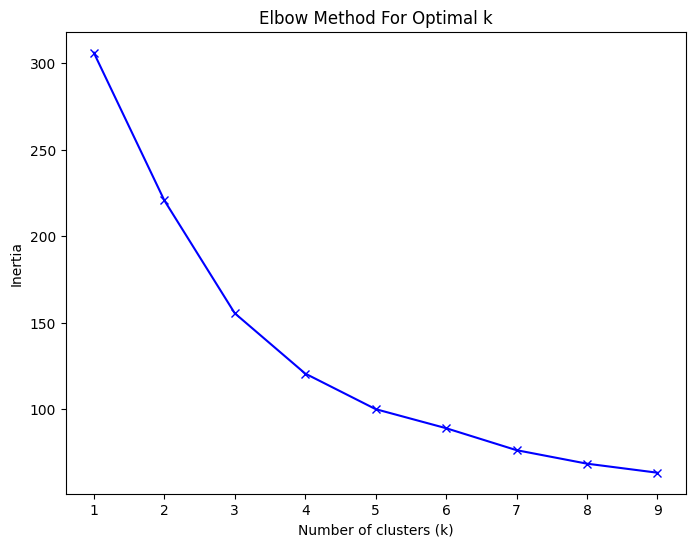

In [87]:
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [88]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
iw_merge['cluster'] = kmeans.fit_predict(df_scaled)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Try and compare winners' donations to losers'

In [181]:
member_key = pd.read_csv('../../cc_election_cleaning/candidate_district_key.csv')

In [185]:
all_cc_df['normalized_mem'].unique()

array(['Rodrigo Camarena', 'Jenny L Low', 'James F Gennaro',
       'Leslie Boghosian Murphy', 'Benjamin Solotaire', 'Elizabeth Adams',
       'Shirley S Paul', 'Lynn Schulman', 'Mercedes Narcisse',
       'Kamillah M Hanks', 'Amoy K Barnes', 'Jaslin Kaur',
       'Charles Barron', 'Shahana Hanif', 'Amanda Farias', 'Amit S Bagga',
       'John Choe', 'Julie Menin', 'Selvena Brooks-Powers', 'Ari Kagan',
       'Rafael Salamanca', 'Keith Powers', 'Marjorie Velazquez',
       'Cordell Cleare', 'Briget Rein', 'Eric Dinowitz',
       'Shekar Krishnan', 'Rita C Joseph', 'Althea V Stevens',
       'Crystal Hudson', 'Wilfredo Florentino', 'Alexa Aviles',
       'Erik Bottcher', 'Juan D Ardila', 'Pierina A Sanchez', 'Julie Won',
       'Carolyn T Tran', 'Alicka Ampry-Samuel', 'Carmen De La Rosa',
       'Adrienne Adams', 'Felicia Singh', 'Kevin C Riley', 'Chi Osse',
       'Tiffany Caban', 'Jesse D Laymon', 'Linda Lee', 'Mariya Markh',
       'Gale Brewer', 'Justin Brannan', 'Jennifer Gutierrez

In [94]:
fuzzy_all_cc_df = fuzzy_merge(member_key, all_cc_df,  'DefaultBallotName','normalized_mem', threshold=80)

In [188]:
#drop fuzzy_all_cc_df index 287
fuzzy_all_cc_df = fuzzy_all_cc_df.drop(index=287)

In [ ]:
fuzzy_all_cc_df

,DefaultBallotName,normalized_mem,score
0,Erin Hussein,Erin Z Hussein,92
1,Carlina Rivera,Carlina Rivera,100
2,Carmen N. De La Rosa,Carmen De La Rosa,94
3,James E. Behr,James E Behr,100
4,Angela Fernandez,Angela Fernandez,100
...,...,...,...
283,Marko Kepi,Marko Kepi,100
284,David M. Carr,David M Carr,100
285,Jordan Hafizi,Jordan Hafizi,100
286,Kathleen Sforza,Kathleen Sforza,100


In [186]:
new_row = {'DefaultBallotName': 'Kristin Richardson Jordan', 'normalized_mem': 'Kristin R Jordan', 'score': 100}
fuzzy_all_cc_df = pd.concat([fuzzy_all_cc_df, pd.DataFrame([new_row])], ignore_index=True)

In [190]:
# find DefaultBallotName in member key but not fuzzy_all_cc_df
missing_members = member_key[~member_key['DefaultBallotName'].isin(fuzzy_all_cc_df['DefaultBallotName'])]

In [191]:
# rename DefaultBallotName to normalized_mem
missing_members = missing_members.rename(columns={'DefaultBallotName':'normalized_mem'})

In [130]:
fuzzy_all_cc_df

,DefaultBallotName,normalized_mem,score
0,Erin Hussein,Erin Z Hussein,92
1,Carlina Rivera,Carlina Rivera,100
2,Carmen N. De La Rosa,Carmen De La Rosa,94
3,James E. Behr,James E Behr,100
4,Angela Fernandez,Angela Fernandez,100
...,...,...,...
283,Marko Kepi,Marko Kepi,100
284,David M. Carr,David M Carr,100
285,Jordan Hafizi,Jordan Hafizi,100
286,Kathleen Sforza,Kathleen Sforza,100


In [192]:
member_key = member_key.merge(fuzzy_all_cc_df, left_on='DefaultBallotName', right_on='DefaultBallotName', how='left')

In [99]:
def find_real_name(df):
    if df['normalized_mem'] == df['DefaultBallotName']:
        return df['normalized_mem']
    else:
        return df['DefaultBallotName']

In [193]:
member_key['real_name'] = member_key.apply(find_real_name, axis=1)

In [200]:
member_key['DefaultBallotName'].unique()

array(['Erin Hussein', 'Carlina Rivera', 'Carmen N. De La Rosa',
       'James E. Behr', 'Angela Fernandez', 'Francesca M. Castellanos',
       'Johanna Garcia', 'Josue Perez', 'Tirso S. Pina', 'Thomas A. Leon',
       'Christopher Marte', 'Susan Damplo', 'Susan Lee', 'Gigi Li',
       'Jenny L. Low', 'Sean C. Hayes', 'Maud Maron',
       'Tiffany Johnson-Winbush', 'Denny R. Salas',
       'Leslie Boghosian Murphy', 'Erik D. Bottcher',
       'Phelan D. Fitzpatrick', 'Marni Halasa', 'Aleta A. LaFargue',
       'Arthur Z. Schwartz', 'Rebecca N. Lamorte', 'Julie Menin',
       'Kim Moscaritolo', 'Tricia M. Shimamura', 'Billy Freeland',
       'Marco A. Tamayo', 'Christopher  A. Sosa', 'Gale A. Brewer',
       'David Gold', 'Maria Danzilo', 'Zachary Tov Weiner',
       'Jeffrey Omura', 'Sara Lind', 'Luis Tejada', 'Carmen R. Quinones',
       'Stacy R. Lynch', 'Corey Ortega', 'Shaun Abreu', 'Maria Ordonez',
       'Lena Melendez', 'Marti Gould  Allen-Cummings', 'Daniel M. Cohen',
       'R

In [201]:
member_key = member_key[['normalized_mem','district']]

In [202]:
member_key['normalized_mem'].unique()

array(['Erin Z Hussein', 'Carlina Rivera', 'Carmen De La Rosa',
       'James E Behr', 'Angela Fernandez', 'Francesca M Castellanos',
       'Johanna Garcia', 'Josue G Perez', 'Tirso S Pina', 'Thomas A Leon',
       'Christopher Marte', 'Susan M Damplo', 'Susan Lee', 'Gigi Li',
       'Jenny L Low', 'Sean C Hayes', 'Maud Maron', nan, 'Denny R Salas',
       'Leslie Boghosian Murphy', 'Erik Bottcher',
       'Phelan-Dante Fitzpatrick', 'Marni Halasa', 'Aleta A LaFargue',
       'Arthur Z Schwartz', 'Rebecca Lamorte', 'Julie Menin',
       'Kim Moscaritolo', 'Tricia Shimamura', 'Billy Freeland',
       'Marco A Tamayo', 'Christopher A Sosa', 'Gale Brewer',
       'David Gold', 'Maria A Danzilo', 'Jeffrey Omura', 'Sara K Lind',
       'Luis M Tejada', 'Carmen Quinones', 'Stacy R Lynch',
       'Corey Ortega', 'Shaun Abreu', 'Maria Ordonez', 'Lena A Melendez',
       'Marti G Allen-Cummings', 'Daniel M Cohen', 'Raymond Sanchez',
       'Keith Harris', 'Miguel Estrella', 'Diana I Ayala', 'T

In [203]:
member_key = pd.concat([member_key, missing_members], ignore_index=True)

In [204]:
member_key.to_csv('../data/member_key.csv', index=False)

In [205]:
all_cc_df_dis = pd.merge(all_cc_df, member_key, on='normalized_mem', how='left')

In [207]:
all_cc_df_dis[all_cc_df_dis['normalized_mem'] == 'Kristin R Jordan']

,REFNO,DATE,NAME,RECIPNAME,AMNT,SCHEDULE,C_CODE,PURPOSECD,OCCUPATION,EMPNAME,ZIP,normalized_mem,matched_name,district
366,R0006868,3/11/2021,"Abelskamp, Julian","Jordan, Kristin R",10.0,ABC,IND,NaN,Not Employed,Not Employed,10027,Kristin R Jordan,Kristin R Jordan,9.0
425,R0006513,2/13/2021,"Abraha, Alex","Jordan, Kristin R",15.0,ABC,IND,NaN,Educator,University,55429,Kristin R Jordan,Kristin R Jordan,9.0
921,R0001930,6/26/2020,"Acquah, Samuel","Jordan, Kristin R",300.0,ABC,IND,NaN,Physician,Mount Sinai,07632,Kristin R Jordan,Kristin R Jordan,9.0
1146,R0000571,12/6/2019,"Adams, Kalima","Jordan, Kristin R",20.0,ABC,IND,NaN,Hairdresser,Self-employed,10458,Kristin R Jordan,Kristin R Jordan,9.0
1159,R0010137,9/20/2021,"Adams, Lorraine","Jordan, Kristin R",175.0,ABC,IND,NaN,Author,Self-Employed,10035,Kristin R Jordan,Kristin R Jordan,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164465,R0006056,1/11/2021,"Zorio, Stephen","Jordan, Kristin R",23.0,ABC,IND,NaN,Marketing Specialist,Amazon,10026,Kristin R Jordan,Kristin R Jordan,9.0
164655,R0008781,6/25/2021,"Zurkuhlen, Michael","Jordan, Kristin R",45.0,ABC,IND,NaN,Teacher,Calhoun School,10032,Kristin R Jordan,Kristin R Jordan,9.0
164656,R0010135,9/20/2021,"Zurkuhlen, Michael","Jordan, Kristin R",25.0,ABC,IND,NaN,Teacher,The Calhoun School,10032,Kristin R Jordan,Kristin R Jordan,9.0
164657,R0006880,3/11/2021,"Zurkuhlen, Michael","Jordan, Kristin R",25.0,ABC,IND,NaN,Teacher,Calhoun School,10032,Kristin R Jordan,Kristin R Jordan,9.0


In [208]:
dis_fundraising = all_cc_df_dis.groupby(['district','normalized_mem'])['AMNT'].sum().reset_index(name='total')

In [209]:
dis_fundraising['district_toal'] = dis_fundraising.groupby('district')['total'].transform('sum')

In [210]:
dis_fundraising['perc_total'] = (dis_fundraising['total'] / dis_fundraising['district_toal']) * 100

In [211]:
dis_fundraising['highest_amount'] = dis_fundraising.groupby('district')['total'].transform('max')

In [212]:
dis_fundraising['perc_highest'] = (dis_fundraising['total'] / dis_fundraising['highest_amount']) * 100

In [213]:
df_join = dis_fundraising[['normalized_mem','perc_total','perc_highest']]

In [243]:
df_join.shape

(288, 3)

Try cluster again with additional data

In [216]:
iw_merge = pd.merge(iw_merge, df_join, on='normalized_mem')

In [217]:
iw_merge['normalized_mem'].unique()

array(['Adrienne Adams', 'Alexa Aviles', 'Althea V Stevens',
       'Amanda Farias', 'Ari Kagan', 'Carlina Rivera',
       'Carmen De La Rosa', 'Charles Barron', 'Chi Osse',
       'Christopher Marte', 'Crystal Hudson', 'Darlene Mealy',
       'David M Carr', 'Diana I Ayala', 'Eric Dinowitz', 'Erik Bottcher',
       'Farah Louis', 'Francisco P Moya', 'Gale Brewer',
       'James F Gennaro', 'Jennifer Gutierrez', 'Joann Ariola',
       'Julie Menin', 'Julie Won', 'Kamillah M Hanks', 'Kevin C Riley',
       'Kristin R Jordan', 'Lincoln Restler', 'Linda Lee',
       'Lynn Schulman', 'Marjorie Velazquez', 'Mercedes Narcisse',
       'Nantasha Williams', 'Oswald Feliz', 'Pierina A Sanchez',
       'Rafael Salamanca', 'Rita C Joseph', 'Robert F Holden',
       'Sandra Ung', 'Sandy Nurse', 'Selvena Brooks-Powers',
       'Shahana Hanif', 'Shaun Abreu', 'Shekar Krishnan', 'Tiffany Caban',
       'Vickie Paladino'], dtype=object)

In [223]:
iw_merge.columns = ['normalized_mem', 'count', 'total_amount', 'mean_amount','home_district_percentage', 'oos_percentage','perc_IND_value','perc_total','perc_highest']

In [224]:
columns_for_clustering = ['total_amount','count', 'mean_amount', 'home_district_percentage', 'oos_percentage','perc_IND_value','perc_total','perc_highest']

In [225]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(iw_merge[columns_for_clustering])

In [226]:
inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

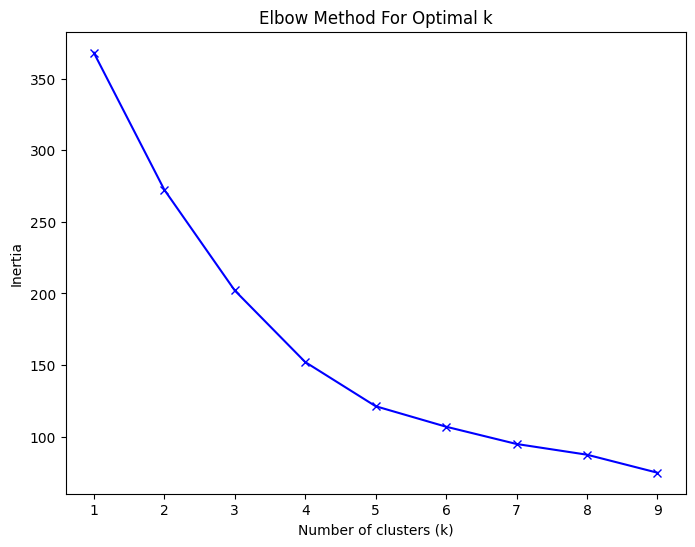

In [227]:
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [228]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
iw_merge['finance_cluster'] = kmeans.fit_predict(df_scaled)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [229]:
iw_merge[['perc_IND_value','normalized_mem','finance_cluster','mean_amount','perc_total','home_district_percentage', 'oos_percentage',]].sort_values('oos_percentage', ascending=False)

,perc_IND_value,normalized_mem,finance_cluster,mean_amount,perc_total,home_district_percentage,oos_percentage
35,91.860525,Rafael Salamanca,2,607.161125,97.674565,6.985770,40.491591
23,94.763636,Julie Won,4,101.735391,16.168912,19.143577,32.871537
32,86.882563,Nantasha Williams,4,81.509393,21.278774,18.997361,27.440633
44,91.794469,Tiffany Caban,4,45.088936,42.868978,17.101449,25.383023
36,90.745980,Rita C Joseph,4,95.112706,24.206036,22.331155,23.093682
34,87.428823,Pierina A Sanchez,4,64.956515,30.948199,14.241245,21.712062
8,83.912556,Chi Osse,4,47.850285,31.921326,11.046512,20.764120
2,71.531572,Althea V Stevens,0,62.539026,34.445552,10.252101,20.504202
42,83.488915,Shaun Abreu,1,120.939318,18.217516,35.179153,20.195440
43,90.608775,Shekar Krishnan,1,113.217042,32.347419,49.328449,19.536020


In [230]:
iw_merge.to_csv('../data/winning_members_clusters.csv', index=False)

In [242]:
iw_merge.shape

(46, 10)

In [5]:
iw_merge = pd.read_csv('../data/winning_members_clusters.csv')

In [ ]:
iw_merge[['normalized_mem','cluster','total_amount','mean_amount','home_district_percentage','oos_percentage',]].sort_values('cluster')

Cluster with groups

In [224]:
groups = pd.read_csv('../data/group_export.csv')

In [225]:
group_iw = pd.merge(iw_merge, groups, on='normalized_mem', how='left')

In [227]:
# replace NaN with 0
group_iw = group_iw.fillna(0)

In [228]:
group_iw.columns

Index(['normalized_mem', 'count', 'total_amount', 'mean_amount',
       'home_district_percentage', 'oos_percentage', 'perc_IND_value',
       'perc_total', 'perc_highest', 'cluster', 'dsa_wfp', 'stonewall',
       'dc_37', 'twu', 'cops', 'sanitation', 'firemen', 'carpenters', 'psc',
       'teachers', 'tile', 'acec', 'cwa', 'hotel', 'nysl', 'seiu',
       'ironworkers', 'afl_cio'],
      dtype='object')

In [235]:
columns_for_clustering = ['total_amount', 'mean_amount', 'home_district_percentage', 'oos_percentage','perc_IND_value','perc_total',
                          'dsa_wfp', 
       'dc_37', 'twu', 'cops', 
       'teachers', 'tile',  'hotel', 'nysl', 'seiu',
        'afl_cio']

In [236]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(group_iw[columns_for_clustering])

In [237]:
inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

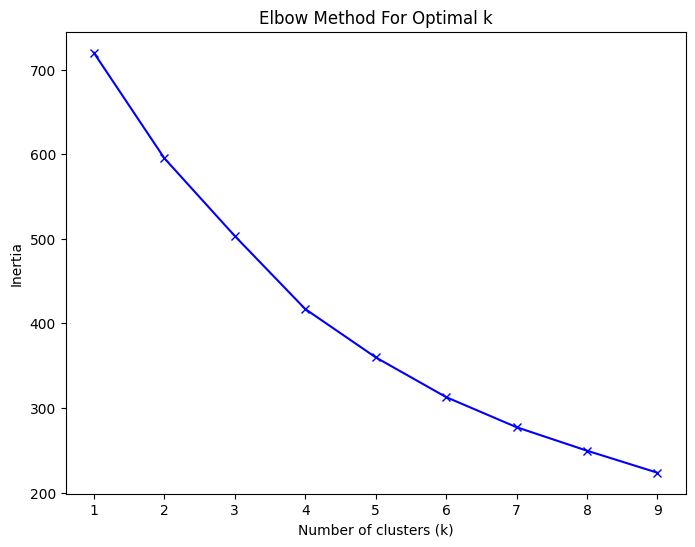

In [238]:
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [239]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
group_iw['cluster'] = kmeans.fit_predict(df_scaled)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
group_iw[['normalized_mem','cluster']].sort_values('cluster')

All candidates 

In [104]:
columns_for_clustering = ['count', 'total_amount', 'mean_amount', 'home_district_percentage', 'oos_percentage','perc_IND_value']

In [174]:
#drop nan
iw_merge_all = iw_merge_all.dropna(subset=columns_for_clustering)

In [175]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(iw_merge_all[columns_for_clustering])

In [176]:
inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

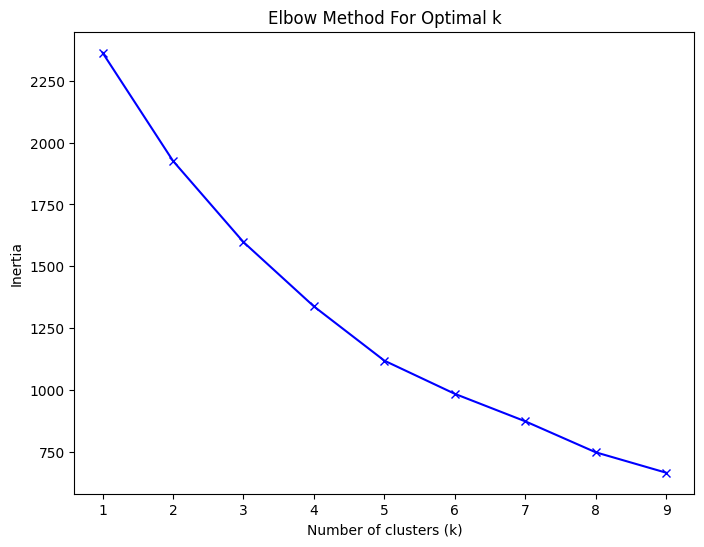

In [177]:
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [190]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
iw_merge_all['cluster'] = kmeans.fit_predict(df_scaled)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\samtg\AppData\Local\Temp\ipykernel_2308\3038395397.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iw_merge_all['cluster'] = kmeans.fit_predict(df_scaled)


In [191]:
iw_merge_all['cluster'].value_counts()

cluster
3    140
4    129
0     86
2     30
1      9
Name: count, dtype: int64

In [192]:
iw_merge_all[iw_merge_all['cluster'] == 0][['matched_name','cluster','total_amount','mean_amount','home_district_percentage','oos_percentage']].sort_values('mean_amount').head(25)

,matched_name,cluster,total_amount,mean_amount,home_district_percentage,oos_percentage
164,Jaslin Kaur,0,48795.11,33.744889,10.434174,20.518207
51,Brandon West,0,76463.44,37.482078,24.962705,17.901542
263,Michael D Hollingsworth,0,83755.82,39.488835,19.033955,14.442850
305,Rene Hill,0,31564.00,41.531579,19.002695,5.525606
273,Mohammed N Mujumder,0,38387.00,41.815904,20.043573,3.267974
204,Kaled A Alamarie,0,38028.00,43.610092,21.288838,7.364787
365,Tiffany Caban,0,111910.74,45.088936,17.101449,25.383023
336,Shahana Hanif,0,88402.88,45.172652,38.868708,13.907628
15,Alexa Aviles,0,78261.53,46.063290,16.746988,18.614458
3,Adolfo Abreu,0,70624.56,46.280839,8.168643,19.104084


In [193]:
iw_merge_all.to_csv('../data/all_members_clusters.csv', index=False)

Everything above this was done in the Fall of '24 for the original chapter. Below is looking at it again Feb '25 for edits. 

In [245]:
df = pd.read_csv('../data/winning_members_donations.csv')

In [246]:
df.shape

(51, 7)

In [247]:
test_again = df.copy()

In [248]:
test_again.columns

Index(['normalized_mem', 'count', 'total', 'mean', 'home_district_percentage',
       'oos_percentage', 'perc_IND_value'],
      dtype='object')

In [249]:
cluster_cols = ['mean', 'home_district_percentage', 'oos_percentage','perc_IND_value']

In [250]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(test_again[cluster_cols])

In [252]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
test_again['cluster'] = kmeans.fit_predict(df_scaled)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [254]:
test_again[test_again['cluster'] == 3][['normalized_mem','cluster']]

,normalized_mem,cluster
1,Alexa Aviles,3
3,Amanda Farias,3
8,Chi Osse,3
10,Crystal Hudson,3
25,Julie Won,3
31,Kristin R Jordan,3
37,Nantasha Williams,3
39,Pierina A Sanchez,3
41,Rita C Joseph,3
44,Sandy Nurse,3


In [255]:
test_again.to_csv('../data/winning_members_clusters_with_gop.csv', index=False)